In [1]:
%load_ext autoreload
%autoreload 2

## Training embedding

In [2]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login

tqdm.pandas()

In [51]:
notebook_login()

In [3]:
logging.basicConfig(
    format='%(asctime)s - %(message)s',
    level=logging.INFO,
    handlers=[LoggingHandler()]
)

In [6]:
train_data = pd.read_csv("data/real_labels.csv", index_col=0)

In [16]:
train_data['label'] = train_data['event'].map({
    "no": 0,
    "yes": 1,
    "penalty" : 1,
    "goal" : 1
})

In [1]:
train_data

NameError: name 'train_data' is not defined

In [23]:
train = train_data.query("MatchID ==4")
val = train_data.query("MatchID in [0,2]")

In [28]:

def generate_text_pairs_from_data(data, num_pairs):

    # Generate random pairs of indices
    np.random.seed(42)  # Set seed for reproducibility
    indices = np.random.choice(len(data), size=(num_pairs, 2))

    # Extract the rows corresponding to the pairs
    x1 = data.iloc[indices[:, 0]].reset_index(drop=True)
    x2 = data.iloc[indices[:, 1]].reset_index(drop=True)

    # Calculate target y: 1 if EventType is the same, 0 otherwise
    y = (x1['EventType'] == x2['EventType']).astype(int)

    # Combine x1, x2, and y into a DataFrame
    pairs = pd.DataFrame({
        'x1': x1['originalTweet'],
        'x2': x2['originalTweet'],
        'x1_EventType': x1['EventType'],
        'x2_EventType': x2['EventType'],
        'y': y
    })
    
    pairs['Input'] = pairs.progress_apply(lambda row : InputExample(texts=[row['x1'], row['x2']], label=float(row['y'])), axis=1)
    return pairs

In [29]:
training_pairs = generate_text_pairs_from_data(train, 10_000)
validation_pairs = generate_text_pairs_from_data(val, 10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 153035.46it/s]


In [30]:
training_pairs

,x1,x2,x1_EventType,x2_EventType,y,Input
0,Grrrr! Germany what are you doing there?! 😬😬 #...,#ALG fuckin wants some bruhhh,1,0,0,"<InputExample> label: 0.0, texts: Grrrr! Germa..."
1,This is looking better so far. Germany pls,germany v netherlands baby,1,1,1,"<InputExample> label: 1.0, texts: This is look..."
2,Cousin asked why some players weren't singing ...,get ur shit together Germany,1,1,1,"<InputExample> label: 1.0, texts: Cousin asked..."
3,#ALG team is fasting and they're still playing...,Intensity levels from Algeria superb. Doubtful...,0,1,0,"<InputExample> label: 0.0, texts: #ALG team is..."
4,You can tell Germany will score,This game was way too intense! Algeria put up ...,0,1,0,"<InputExample> label: 0.0, texts: You can tell..."
...,...,...,...,...,...,...
9995,I'd like to retract previous tweet. Algeria lo...,0-0 wtf and Germany is suppose to be the best?!,0,1,0,"<InputExample> label: 0.0, texts: I'd like to ..."
9996,Algeria's counter attack is dangerous,Algeria! Just do it! #GERALG #CoupeDuMonde,1,0,0,"<InputExample> label: 0.0, texts: Algeria's co..."
9997,Algeria are seriously balling #WorldCupTalks #...,Algeria is getting a little too close for my l...,0,0,1,"<InputExample> label: 1.0, texts: Algeria are ..."
9998,I’m following Germany versus Algeria in the FI...,Cmon Germany needs to win!,1,0,0,"<InputExample> label: 0.0, texts: I’m followin..."


In [31]:
training_pairs['y'].value_counts(), validation_pairs['y'].value_counts()

(y
 0    5010
 1    4990
 Name: count, dtype: int64,
 y
 1    6105
 0    3895
 Name: count, dtype: int64)

In [32]:
train_dataloader = DataLoader(training_pairs['Input'], shuffle=False, batch_size=128)
validation_dataloader = DataLoader(validation_pairs['Input'], shuffle=False, batch_size=128)

In [33]:
validation_examples = validation_pairs['Input'].tolist()

In [ ]:
cache_dir = '/Data'

# Load a pre-trained model with a custom cache directory
model = SentenceTransformer('whaleloops/phrase-bert', cache_folder=cache_dir)

train_loss = losses.CosineSimilarityLoss(model=model)

# Step 5: Define Evaluator
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(validation_examples, name="validation", show_progress_bar = True)

# Step 6: Training with Validation Checkpoint
num_epochs = 20
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training for warmup

# Directory to save the best model
output_dir = 'output/sentence-transformer-best-model'
os.makedirs(output_dir, exist_ok=True)

# Variable to track the best validation score
best_validation_score = -float('inf')
best_model = None

# Training loop with validation
for epoch in range(num_epochs):
    logging.info(f"Starting epoch {epoch + 1}/{num_epochs}")
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,  # Train one epoch at a time
        warmup_steps=warmup_steps // num_epochs,
        show_progress_bar=True,
        use_amp=True
    )

    # Evaluate after every epoch
    validation_score = evaluator(model)
    logging.info(f"Validation score for epoch {epoch + 1}: {validation_score}")

    # Save model if it's the best so far
    if validation_score['validation_spearman_cosine'] > best_validation_score:
        clear_output()
        logging.info(f"New best validation score: {validation_score}. Saving model...")
        best_model = deepcopy(model)
        best_validation_score = validation_score['validation_spearman_cosine']

# Final model saved at the best-validation checkpoint
logging.info(f"Training complete. Best model saved at: {output_dir}")

2024-11-19 08:55:58,570 - New best validation score: {'validation_pearson_cosine': 0.02846063103914722, 'validation_spearman_cosine': 0.023686204639121747}. Saving model...
2024-11-19 08:55:58,575 - Deep copying the `Accelerator` object, note that this will point to the same original object.
2024-11-19 08:55:58,576 - Deep copying the `Accelerator` object, note that this will point to the same original object.
2024-11-19 08:55:58,625 - Starting epoch 2/20


/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss


2024-11-19 08:56:15,113 - EmbeddingSimilarityEvaluator: Evaluating the model on the validation dataset:


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2024-11-19 08:56:25,747 - Cosine-Similarity :	Pearson: 0.0274	Spearman: 0.0234
2024-11-19 08:56:25,747 - Validation score for epoch 2: {'validation_pearson_cosine': 0.027436676286390703, 'validation_spearman_cosine': 0.023441512369330977}
2024-11-19 08:56:25,747 - Starting epoch 3/20


/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss


2024-11-19 08:56:42,421 - EmbeddingSimilarityEvaluator: Evaluating the model on the validation dataset:


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2024-11-19 08:56:53,083 - Cosine-Similarity :	Pearson: 0.0216	Spearman: 0.0197
2024-11-19 08:56:53,083 - Validation score for epoch 3: {'validation_pearson_cosine': 0.021609457695094363, 'validation_spearman_cosine': 0.0196636825175622}
2024-11-19 08:56:53,083 - Starting epoch 4/20


/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss


2024-11-19 08:57:09,921 - EmbeddingSimilarityEvaluator: Evaluating the model on the validation dataset:


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2024-11-19 08:57:20,575 - Cosine-Similarity :	Pearson: 0.0134	Spearman: 0.0112
2024-11-19 08:57:20,576 - Validation score for epoch 4: {'validation_pearson_cosine': 0.013409040500986276, 'validation_spearman_cosine': 0.011193152906987237}
2024-11-19 08:57:20,576 - Starting epoch 5/20


/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss


KeyboardInterrupt: 

: 

In [21]:
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(validation_examples, name="validation", show_progress_bar = True)

In [52]:
best_model.push_to_hub("peulsilva/sentence-transformer-trained-tweet")

2024-11-17 13:36:38,223 - Save model to /tmp/tmpn2rqqev4


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

'https://huggingface.co/peulsilva/sentence-transformer-trained-tweet/commit/7f852f01ac936a60bf85e95921b065afa0bc43ee'

In [45]:
samples = validation_pairs.sample(1000)
vectors = best_model.encode(samples['x1'].tolist())

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [46]:
pca = PCA(n_components=2)
r2_vectors = pca.fit_transform(vectors)

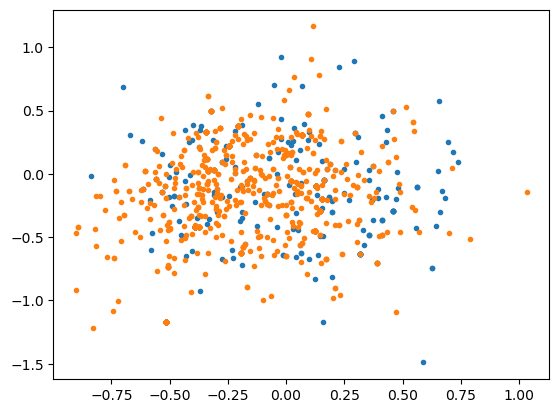

In [47]:
for class_label in np.unique(samples['x1_EventType']):
    # Filter vectors for each class
    class_vectors = vectors[samples['x1_EventType'] == class_label]
    plt.scatter(class_vectors[:, 0], class_vectors[:, 1], label=f'Class {class_label}',marker='.')


In [ ]:
validation_score

{'validation_pearson_cosine': 0.11487466062640127,
 'validation_spearman_cosine': 0.11886362634054483}